# Task Description  

We want to promote tipping to retain our driver base and increase the driver engagement.

Could you find the relation between:

    the trip duration
    trips
    distance
    location id
    vendor
    passenger count

and tip amount, and make suggestions on rolling out some experimentations?


In [1]:
import pandas as pd 
from pandas.tseries.offsets import Week
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/svujovic/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_rides = pd.read_pickle('../data/full_cleaned_trip_data.pkl')

In [3]:
df_rides = pd.concat([df_rides, pd.get_dummies(df_rides['tpep_pickup_datetime'].dt.dayofweek)], axis=1)
df_rides = pd.concat([df_rides, pd.get_dummies(df_rides['VendorID']).rename(columns={1:'first_vendor',2:'second_vendor'})], axis=1)

In [4]:
# proportion of rides with no tip
len(df_rides[df_rides['tip_amount']==0])/len(df_rides)

0.3284174709351518

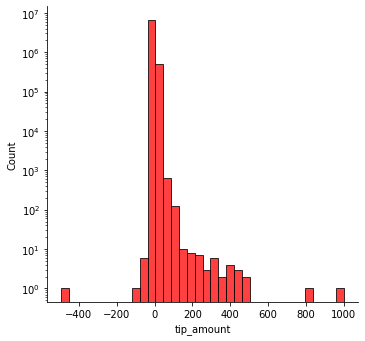

In [5]:
sns.displot(df_rides, x='tip_amount', kind='hist', 
             bins=int(180/5), color = 'red',)
plt.yscale('log')

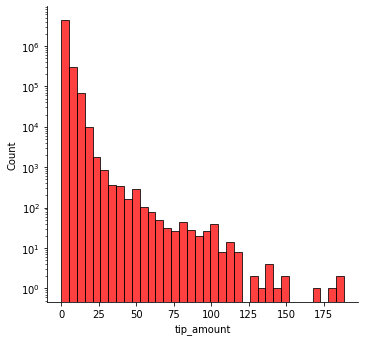

In [6]:
sns.displot(df_rides[(df_rides['tip_amount'] < 200) & (df_rides['tip_amount'] > 0)], x='tip_amount', kind='hist', 
             bins=int(180/5), color = 'red',)
plt.yscale('log')

In [7]:
df_rides['trip_duration'] = df_rides['tpep_dropoff_datetime'] - df_rides['tpep_pickup_datetime']
df_rides['trip_duration'] = df_rides['trip_duration'].dt.total_seconds().div(60).astype(int)

In [8]:
# there is probably some interaction between trip distance and trip duration
df_rides['dist_dur_int'] = df_rides['trip_duration']*df_rides['trip_distance']

In [9]:
df_rides['weekday'] = df_rides['tpep_pickup_datetime'].dt.dayofweek

In [10]:
popularity = df_rides.groupby('PULocationID').agg(departures=('PULocationID', 'count')).reset_index()

In [11]:
# making PU location an ordinal variable
popularity['location_popularity_rank'] = popularity['departures'].rank(ascending=False)

In [12]:
# popularity.sort_values('location_popularity_rank').head()df_
df_rides = df_rides.merge(popularity[['PULocationID', 'location_popularity_rank']])

In [19]:

position_dummies = df_rides['weekday'].unique()
regressors =['trip_distance','trip_duration','passenger_count','dist_dur_int','second_vendor','location_popularity_rank']
regressors.extend(position_dummies)
regressors.remove(0)

Y = df_rides[~df_rides['passenger_count'].isna()]['tip_amount']
X = df_rides[~df_rides['passenger_count'].isna()][regressors]
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                 1.309e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:43:05   Log-Likelihood:            -1.5188e+07
No. Observations:             6767218   AIC:                         3.038e+07
Df Residuals:                 6767205   BIC:                         3.038e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.1319      0.003    381.036      0.000       1.126       1.138
trip_distance                0.3254      0.000   1222.120      0.000       0.325       0.326
trip_duration                0.0005   1.54e-05     29.630      0.000       0.000       0.000
passenger_count              0.0008      0.001      1.015      0.310      -0.001       0.002
dist_dur_int             -6.425e-05   2.11e-06    -30.380      0.000   -6.84e-05   -6.01e-05
second_vendor                0.0291      0.002     15.387      0.000       0.025       0.033
location_popularity_rank    -0.0060    4.8e-05   -124.979      0.000      -0.006      -0.006
2                            0.0712      0.003     22.418      0.000       0.065       0.077
3                            0.0827      0.003     25.790      0.000       0.076       0.089
4                            0.0451      0.003     13.958      0.000       0.039       0.051
5                           -0.0806      0.003    -23.282      0.000      -0.087      -0.074
6                           -0.0435      0.003    -12.544      0.000      -0.050      -0.037
1                            0.0577      0.003     18.062      0.000       0.051       0.064
==============================================================================
Omnibus:                 19094599.752   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   31061295509383.055
Skew:                          35.665   Prob(JB):                         0.00
Kurtosis:                   10498.431   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Possibilities

`Trip distance` as expected plays a role. With an increase of distance the tips are also increased. Potentialy we could potentialy match drivers with a lack of recorded tips to fares that would be long. 

There is aninteraction effect between `trip distance` and `duration`. Seems like finding the shortest path is valued by the customers. I would suggest that we offer some software solution to the cab drivers or maybe send them tips on how to navigate better with the promisse of a potentially better tip. 

The `second vendor` seems to be more suitable for higher tips. Maybe we could run (or simulate) a controlled expeiment to confirm that. If it seems to be the case, we would probably need to come op with some kind of intervention.  

I am not confident in the `location popularity`. Here is why: The most popular location is on position 1 and the least popular one is on position 262. The distribution of rides follows a 'pareto' distribution. The increase from position 5 to 6 and 250 and 251 are not the same.

`Weekday` seems to play a role. Maybe an automated shift planning system could be developed to distribute the drivers hours in a favourable way in order to get more tips.